# __Flight Sentiment Analysis__

In [664]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
#import utils
import spacy
import seaborn as sb

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
#from slang import all_slang_words


warnings.filterwarnings("ignore")

## Importing Dataset for Flight Data

Use the Kaggle dataset containing information about tweets related to flights will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [665]:
# Open file containing flight data
flight_review_df = pd.read_csv("./Dataset/Reviews/airline_review_tweets.csv")
flight_review_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306100000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin test,NaN,0,test only for deletion @VirginAmerica What @dh...,NaN,2015-02-24 11:35,NaN,Eastern Time (US & Canada)
1,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35,NaN,Eastern Time (US & Canada)
2,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15,NaN,Pacific Time (US & Canada)
3,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15,Lets Play,Central Time (US & Canada)
4,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15,NaN,Pacific Time (US & Canada)


In [666]:
# List all the columns in flight data's dataframe
flight_review_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

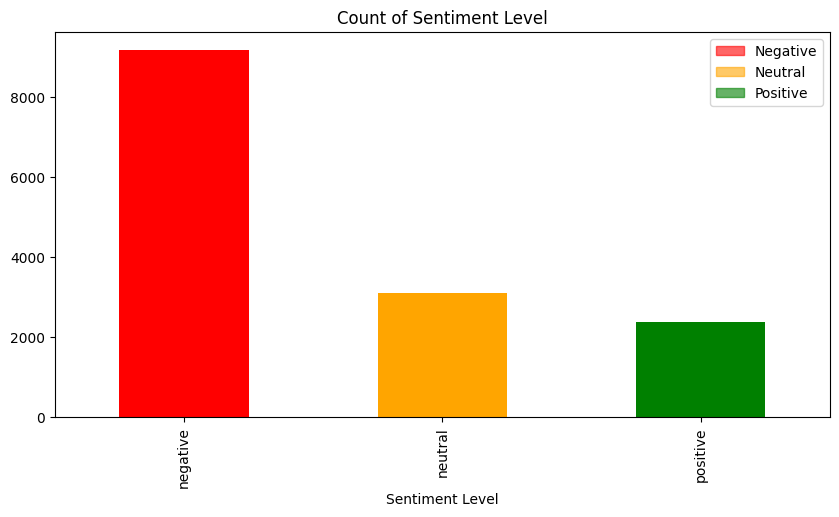

In [667]:
import matplotlib.pyplot as plt

# Define the colors for each sentiment
sentiment_colors = {
    'negative': 'red',
    'neutral': 'orange',
    'positive': 'green'
}

# Count the reviews based on dataset Sentiment Level
sentiment_counts = flight_review_df['airline_sentiment'].value_counts().sort_index()
sentiments = sentiment_counts.index
colors = [sentiment_colors[s] for s in sentiments]

# Create the bar chart
ax = sentiment_counts.plot(kind='bar', title='Count of Sentiment Level', figsize=(10, 5), color=colors)

ax.set_xlabel('Sentiment Level')

# Add a custom legend for sentiments
legend_labels = {
    'negative': 'Negative',
    'neutral': 'Neutral',
    'positive': 'Positive'
}

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=sentiment_colors[s], alpha=0.6, label=label)
                  for s, label in legend_labels.items()]

ax.legend(handles=legend_handles, loc='upper right')

plt.show()


## Exploratory Data Analysis

Renaming columns

In [668]:
# Rename the 'text' column to 'review'
flight_review_df.rename(columns={'text': 'review'}, inplace=True)

# Show DataFrame to check if 'review' column instead of 'text'
flight_review_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,review,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306100000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin test,NaN,0,test only for deletion @VirginAmerica What @dh...,NaN,2015-02-24 11:35,NaN,Eastern Time (US & Canada)
1,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35,NaN,Eastern Time (US & Canada)
2,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15,NaN,Pacific Time (US & Canada)
3,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15,Lets Play,Central Time (US & Canada)
4,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15,NaN,Pacific Time (US & Canada)


Check and resolve duplicate records

In [669]:
# Drop columns that are not relevant
del_columns = ['tweet_id', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold','name','negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_location','user_timezone']
flight_review_df = flight_review_df.drop(del_columns, axis=1)

flight_review_df.head(5)

,airline_sentiment,airline_sentiment_confidence,airline,review,tweet_created
0,neutral,1.0000,Virgin America,test only for deletion @VirginAmerica What @dh...,2015-02-24 11:35
1,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,2015-02-24 11:35
2,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15
3,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15
4,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15


In [670]:
# Drop duplicate records in flight data
print(f"Record count before removing duplicates => {flight_review_df.shape[0]}")
flight_review_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {flight_review_df.shape[0]}")

Record count before removing duplicates => 14641
Record count after removing duplicates  => 14561


Check and resolve missing values for `flight data`

In [671]:
# Check for missing values in flight data
print(flight_review_df.isna().sum())


try:
    # Check for missing values in flight data
    missing_values = flight_review_df.isna().sum()
    
    # Check if there are any missing values
    if missing_values.sum() > 0:
        # Display records with missing values
        print("Records with missing values:")
        missing_records = flight_review_df[flight_review_df.isna().any(axis=1)]
        print(missing_records)
    else:
        print("No missing values found in the flight data.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
review                          0
tweet_created                   0
dtype: int64
No missing values found in the flight data.


In [672]:
# Drop rows with missing values in the specified columns and compare the number of rows before and after dropping

print(f"Record count before removing flight data with missing values => {flight_review_df.shape[0]}")

# Drop rows with missing values in the specified columns
flight_review_df.dropna(subset=['airline_sentiment', 'review', 'tweet_created'], inplace=True)
print(f"Record count after removing  flight data with missing values => {flight_review_df.shape[0]}")


Record count before removing flight data with missing values => 14561
Record count after removing  flight data with missing values => 14561


Check and resolve missing values for `flight reviews`

In [673]:
# Check for missing values in flight reviews
flight_review_df.isna().sum()

airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
review                          0
tweet_created                   0
dtype: int64

In [674]:
# Replace all missing values in flight with a blank
flight_review_df[['review']] = flight_review_df[['review']].fillna('')
flight_review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14561 entries, 0 to 14640
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14561 non-null  object 
 1   airline_sentiment_confidence  14561 non-null  float64
 2   airline                       14561 non-null  object 
 3   review                        14561 non-null  object 
 4   tweet_created                 14561 non-null  object 
dtypes: float64(1), object(4)
memory usage: 682.5+ KB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `flight metadata` to transform and structure data into a desired format

In [675]:
# Convert 'tweet_created' to datetime
flight_review_df['tweet_created'] = pd.to_datetime(flight_review_df['tweet_created'])

# Extract year, month, and day into separate columns
flight_review_df['review_year'] = flight_review_df['tweet_created'].dt.year
flight_review_df['review_month'] = flight_review_df['tweet_created'].dt.month

flight_review_df.head(10)

,airline_sentiment,airline_sentiment_confidence,airline,review,tweet_created,review_year,review_month
0,neutral,1.0000,Virgin America,test only for deletion @VirginAmerica What @dh...,2015-02-24 11:35:00,2015,2
1,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:00,2015,2
2,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:00,2015,2
3,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:00,2015,2
4,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:00,2015,2
5,negative,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:00,2015,2
6,negative,1.0000,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:00,2015,2
7,positive,0.6745,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:00,2015,2
8,neutral,0.6340,Virgin America,@VirginAmerica Really missed a prime opportuni...,2015-02-24 11:12:00,2015,2
9,positive,0.6559,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D",2015-02-24 11:11:00,2015,2


In [676]:
# Show statistical summary of flight review
flight_review_df.describe()

,airline_sentiment_confidence,tweet_created,review_year,review_month
count,14561.000000,14561,14561.0,14561.0
mean,0.899627,2015-02-21 11:10:44.494196736,2015.0,2.0
min,0.335000,2015-02-16 23:36:00,2015.0,2.0
25%,0.691900,2015-02-19 15:36:00,2015.0,2.0
50%,1.000000,2015-02-22 03:49:00,2015.0,2.0
75%,1.000000,2015-02-23 07:45:00,2015.0,2.0
max,1.000000,2015-02-24 11:53:00,2015.0,2.0
std,0.163105,NaN,0.0,0.0


In [677]:
#TODO roBERTa
# # Get the frequency of values in the 'roberta_sentiment' column
# sentiment_counts = flight_review_df['roberta_sentiment'].value_counts()
# sentiment_counts.plot(kind='bar', edgecolor='black')

# plt.xlabel('Sentiments')
# plt.ylabel('Frequency')
# plt.title('Frequency of Flight Reviews Sentiments')
# plt.show()

#### __For Text Pre-processing__:

__The flight review undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Remove "at the rate" and #
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [679]:
import pandas as pd
import demoji
from collections import Counter


# Download the emoji library data
demoji.download_codes()

# Function to extract emojis from a text using demoji
def extract_emojis(text):
    emojis = demoji.findall(text)
    return list(emojis.keys())

# Extract emojis from all reviews
all_emojis = flight_review_df['review'].apply(extract_emojis).sum()
print(all_emojis)
# Count the frequency of each emoji
emoji_counts = Counter(all_emojis)


# Get the top 10 emojis by frequency
top_10_emojis = emoji_counts.most_common(10)

# Display the top 10 emojis and their frequencies
for emoji, count in top_10_emojis:
        print(f"Emoji: {emoji}, Count: {count}")

['❤️', '😢', '👍', '☺️', '💜', '😡', '✈', '👍', '☺️', '❤️', '😡', '😢', '💜', '✈', '👍', '🍷', '💺', '✈️', '😊', '😍', '👌', '💕', '🌞', '✈', '😃', '😩', '😭', '😎', '🙉', '😁', '❤️', '❄️', '👏', '😂', '💗', '🍸', '😒', '👎', '👍', '💗', '✈️', '😊', '😄', '😀', '😃', '😎', '😘', '💗', '👸', '🇺🇸', '😁', '🎀', '💗', '🇺🇸', '🌏', '😍', '🇬🇧', '😥', '🎀', '🇬🇧', '🇺🇸', '😉', '😱', '😍', '✨', '✈️', '✈️', '🎉', '🎀', '💗', '🇺🇸', '😃', '👍', '😁', '💤', '🙌', '😡', '😞', '♥', '👋', '😢', '✌️', '🙏', '❤️', '🙌', '💜', '✈️', '❄️', '😃', '👿', '😉', '😔', '😭', '😊', '🙌', '🙅', '😉', '✈️', '👎', '😡', '✈️', '👏', '👍', '🆖', '😢', '💩', '✔️', '🌴', '❌', '✅', '😡', '😊', '👏', '👍', '👍', '👏', '🙏', '😡', '😄', '😒', '👠', '🇬🇧', '😜', '👍', '👏', '😞', '😡', '😊', '🎉', '😔', '😊', '😻', '😊', '😕', '👎', '😭', '👍', '👌', '😉', '😢', '👎', '😈', '😡', '😊', '👎', '😉', '😤', '😡', '❄️', '👏', '👍', '😊', '❤️', '😔', '👍', '👌', '😂', '😊', '😀', '😭', '👌', '💪', '😉', '😩', '😢', '😫', '😪', '💔', '😕', '😣', '😬', '👍', '😄', '👏', '💁', '😂', '😋', '😏', '🙌', '😖', '🌟', '✈️', '👍', '✈️', '📱', '😞', '👏', '🍻', '👎', '😞', '😡', '💖', '😢', '😭', '

In [680]:
import pandas as pd
import demoji


# Download the emoji library data
demoji.download_codes()

# Function to replace emojis in a text with their corresponding text descriptions using demoji
def replace_emojis_with_text(text):
    #return demoji.replace_with_desc(text)
    return demoji.replace_with_desc(text, sep=' ')

# Replace emojis in the 'review' column
flight_review_df['review'] = flight_review_df['review'].apply(replace_emojis_with_text)

# Display the DataFrame with emojis replaced by text
print(flight_review_df['review'])

0        test only for deletion @VirginAmerica What @dh...
1                      @VirginAmerica What @dhepburn said.
2        @VirginAmerica plus you've added commercials t...
3        @VirginAmerica I didn't today... Must mean I n...
4        @VirginAmerica it's really aggressive to blast...
                               ...                        
14636    @AmericanAir thank you we got on a different f...
14637    @AmericanAir leaving over 20 minutes Late Flig...
14638    @AmericanAir Please bring American Airlines to...
14639    @AmericanAir you have my money, you change my ...
14640    @AmericanAir we have 8 ppl so we need 2 know h...
Name: review, Length: 14561, dtype: object


In [681]:
# For testing purpose, to check if all the existing emojis in the data set has corresponding text from demoji
text = "'Great flight ['❤️', '👍', '☺️', '❤️', '😡', '😢', '💜', '✈', '👍', '🍷', '💺', '✈️', '😊', '😍', '👌', '💕', '🌞', '✈', '😃', '😩', '😭', '😎', '🙉', '😁', '❤️', '❄️', '👏', '😂', '💗', '🍸', '😒', '👎', '👍', '💗', '✈️', '😊', '😄', '😀', '😃', '😎', '😘', '💗', '👸', '🇺🇸', '😁', '🎀', '💗', '🇺🇸', '🌏', '😍', '🇬🇧', '😥', '🎀', '🇬🇧', '🇺🇸', '😉', '😱', '😍', '✨', '✈️', '✈️', '🎉', '🎀', '💗', '🇺🇸', '😃', '👍', '😁', '💤', '🙌', '😡', '😞', '♥', '👋', '😢', '✌️', '🙏', '❤️', '🙌', '💜', '✈️', '❄️', '😃', '👿', '😉', '😔', '😭', '😊', '🙌', '🙅', '😉', '✈️', '👎', '😡', '✈️', '👏', '👍', '🆖', '😢', '💩', '✔️', '🌴', '❌', '✅', '😡', '😊', '👏', '👍', '👍', '👏', '🙏', '😡', '😄', '😒', '👠', '🇬🇧', '😜', '👍', '👏', '😞', '😡', '😊', '🎉', '😔', '😊', '😻', '😊', '😕', '👎', '😭', '👍', '👌', '😉', '😢', '👎', '😈', '😡', '😊', '👎', '😉', '😤', '😡', '❄️', '👏', '👍', '😊', '❤️', '😔', '👍', '👌', '😂', '😊', '😀', '😭', '👌', '💪', '😉', '😩', '😢', '😫', '😪', '💔', '😕', '😣', '😬', '👍', '😄', '👏', '💁', '😂', '😋', '😏', '🙌', '😖', '🌟', '✈️', '👍', '✈️', '📱', '😞', '👏', '🍻', '👎', '😞', '😡', '💖', '😢', '😭', '😂', '😅', '😔', '😢', '💝', '↔️', '🚫', '😏', '😂', '😜', '😱', '😷', '😁', '😖', '✈️', '⭐', '👍', '❤', '💕', '😃', '🎵', '✈', '❗', '🐴', '😤', '😢', '✈️', '😁', '😍', '😭', '😭', '💔', '😎', '😂', '☺', '😉', '💁', '🙏', '😭', '😜', '♥️', '❤️', '😥', '😆', '😊', '🌴', '❤️', '❤️', '👍', '😖', '✈️', '♥️', '🙏', '♥️', '✈️', '👍', '😃', '❤️', '😩', '😂', '😑', '💕', '🐩', '❤️', '😃', '⤴', '💕', '😍', '😔', '😒', '👎', '😜', '☀️', '😭', '😎', '😜', '❤️', '👊', '😱', '❤️', '😄', '😃', '😀', '😁', '✈️', '😭', '😆', '😭', '🎉', '🙏', '❤️', '💯', '😭', '👍', '✈️', '💩', '😠', '😔', '😍', '❤', '🌏', '✈️', '💺', '✈️', '😜', '☺️', '😭', '😄', '😊', '✈', '☕', '📲', '😠', '👺', '😔', '😉', '🙈', '💘', '😊', '👏', '😏', '💙', '😂', '👉', '🚪', '🙅', '😂', '😉', '😳', '😂', '😆', '😁', '😭', '😵', '😒', '😂', '😂', '😩', '🚶', '😉', '✈️', '🔵', '😭', '😂', '😂', '😂', '😩', '😑', '💙', '😑', '😐', '😕', '👀', '😒', '😒', '😳', '😕', '😭', '😂', '👀', '🍅', '😐', '😑', '❤️', '😊', '😐', '💙', '✌️', '😂', '😎', '👌', '😂', '😒', '💯', '😩', '😩', '😂', '❤️', '😒', '👍', '😭', '😒', '😍', '😃', '😉', '🙏', '☺️', '✈️', '✈️', '🙌', '😕', '🌴', '✈️', '☺️', '😕', '☺', '👍', '✈️', '😊', '😭', '😒', '😊', '😊', '👎', '☺', '✈', '😂', '🎉', '😁', '🆘', '😘', '😞', '😢', '❄️', '⛄', '👍', '😊', '🌞', '👸', '✈️', '😭', '☀️', '💔', '👎', '😷', '😉', '😊', '❤️', '😁', '😄', '😊', '😒', '👺', '🙌', '😘', '💙', '💙', '💙', '😃', '😊', '✈️', '😔', '✨', '❤️', '💙', '👍', '✈', '☕', '😢', '🍷', '👍', '😊', '✈️', '💙', '😂', '😢', '☺️', '👌', '☺️', '😏', '🙏', '❤️', '😏', '🙏', '❤️', '😢', '😩', '😢', '🌴', '💙', '👍', '👍', '👍', '✈️', '💕', '💺', '✈️', '😓', '😔', '😤', '☺️', '😀', '🌴', '✈️', '☀️', '🍸', '🎲', '😊', '😁', '😉', '😂', '❄️', '👍', '👏', '😊', '❤️', '😞', '⭐', '😂', '😡', '😊', '👀', '🙏', '👍', '😉', '👍', '🙏', '😒', '😡', '😡', '😡', '😊', '✈', '⌚', '😂', '👊', '😳', '😡', '✌️', '✌️', '✌️', '👎', '😩', '😭', '😠', '💁', '👋', '❤', '😩', '😑', '🐳', '😡', '☀️', '⛄', '👌', '😡', '😂', '😂', '👍', '😀', '✈️', '💺', '🙏', '✌️', '😊', '⤵', '🙏', '⤵', '🙏', '✌️', '😊', '👏', '😬', '👎', '😡', '✈️', '😒', '😤', '🙏', '✌️', '👿', '🙏', '✌️', '👠', '😑', '😉', '😎', '🙏', '😢', '🙏', '😢', '🙏', '😉', '🙏', '✌️', '😒', '🌞', '✈️', '😕', '😃', '😄', '😁', '😃', '😄', '😉', '😮', '😒', '😄', '🙏', '😳', '😭', '😀', '😡', '😞', '❤️', '✈️', '👎', '😡', '😂', '👌', '😁', '👌', '😩', '😭', '😩', '😭', '💔', '👀', '😐', '👍', '😫', '😡', '✈️', '✈️', '😜', '😥', '😐', '✈️', '😋', '😢', '✈️', '😭', '🙏', '💝', '😄', '😤', '👎', '😲', '😖', '😩', '😤', '😡', '😑', '😘', '😥', '✈️', '🇺🇸', '😩', '😢', '😦', '😕', '😳', '😒', '👍', '😡', '❤', '😒', '😃', '😓', '😭', '✈', '➡️', '😕', '😃', '✈️', '✈️', '✌️', '😂', '👌'"

demoji.findall(text)

{'💤': 'zzz',
 '👺': 'goblin',
 '😐': 'neutral face',
 '🆘': 'SOS button',
 '🙅': 'person gesturing NO',
 '🆖': 'NG button',
 '👠': 'high-heeled shoe',
 '😃': 'grinning face with big eyes',
 '😣': 'persevering face',
 '✌️': 'victory hand',
 '💕': 'two hearts',
 '🎲': 'game die',
 '👀': 'eyes',
 '😲': 'astonished face',
 '😩': 'weary face',
 '😈': 'smiling face with horns',
 '😫': 'tired face',
 '👿': 'angry face with horns',
 '😞': 'disappointed face',
 '➡️': 'right arrow',
 '⤵': 'right arrow curving down',
 '💺': 'seat',
 '♥️': 'heart suit',
 '🚪': 'door',
 '⤴': 'right arrow curving up',
 '❤': 'red heart',
 '😖': 'confounded face',
 '😢': 'crying face',
 '😁': 'beaming face with smiling eyes',
 '🙌': 'raising hands',
 '😜': 'winking face with tongue',
 '😦': 'frowning face with open mouth',
 '❤️': 'red heart',
 '💔': 'broken heart',
 '🚶': 'person walking',
 '💖': 'sparkling heart',
 '🚫': 'prohibited',
 '😷': 'face with medical mask',
 '😂': 'face with tears of joy',
 '😳': 'flushed face',
 '⌚': 'watch',
 '😭': 'loud

In [682]:
# import pandas as pd
# import demoji


# # Download the emoji library data
# demoji.download_codes()

# # Function to replace emojis in a text with their corresponding text descriptions using demoji
# def replace_emojis_with_text(text):
#     return demoji.replace_with_desc(text)

# # Replace emojis in the 'review' column
# flight_review_df['review'] = flight_review_df['review'].apply(replace_emojis_with_text)

# # Display the DataFrame with emojis replaced by text
# #print(flight_review_df['review'])
# print(flight_review_df['review'][0])

In [683]:
import demoji
#emoji_dict = tp.get_emojis()
#emoji_dict = tp.extract_emojis()
#slang_word_dict = tp.get_slang_words(webscraped=False)
from text_preprocessing import get_emojis
slang_word_dict = tp.webscrape_slang_words()


def initial_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)
        text = tp.remove_attherate(text)
        text = tp.remove_hashtag(text)    

        # # Replace non-ascii characters as there are Python libraries limiting this feature
        # text = tp.replace_nonascii_characters(text)

        #TODO
        # Download the emoji library data
#        demoji.download_codes()
        # Replace emojis with English word/s
        # Replace emojis in the 'review' column
        # flight_review_df['review'] = flight_review_df['review'].apply(replace_emojis_with_text)
#        text = emoji_dict.replace_keywords(text)
#        text = emoji_dict.replace_keywords(text)


        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


#flight_review_df['cleaned_review'] = flight_review_df['review'].applymap(initial_text_preprocessing)
flight_review_df['cleaned_review'] = flight_review_df['review'].apply(initial_text_preprocessing)


# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review:")
    print(flight_review_df['review'][i])
    print("\nCleaned Review Summary:")
    print(flight_review_df['cleaned_review'][i])
    print("="*100)

Original Review:
test only for deletion @VirginAmerica What @dhepburn said. #hastag before   red heart   red heart  thumbs up  smiling face  red heart  pouting face  crying face  purple heart  airplane  emoji before brb ikr lmao

Cleaned Review Summary:
test only for deletion VirginAmerica What dhepburn said. hastag before   red heart   red heart  thumbs up  smiling face  red heart  pouting face  crying face  purple heart  airplane  emoji before be right back i know really laughing my ass off
Original Review:
@VirginAmerica What @dhepburn said.

Cleaned Review Summary:
VirginAmerica What dhepburn said.
Original Review:
@VirginAmerica plus you've added commercials to the experience... tacky.

Cleaned Review Summary:
VirginAmerica plus you've added commercials to the experience... tacky.
Original Review:
@VirginAmerica I didn't today... Must mean I need to take another trip!

Cleaned Review Summary:
VirginAmerica I didn't today... Must mean I need to take another trip!
Original Review:
@

__Utilize regular expressions to eliminate punctuation, substitute whitespaces, and filter out stopwords from flight reviews__

In [684]:
# Initialize the English stop words list
list_of_stopwords = set(stopwords.words('english'))

def supplemental_text_preprocessing(text):

    # Remove leading and trailing whitespaces
    text = text.strip()

    # Replace multiple whitespaces with a single space
    text = tp.replace_whitespace(text)

    # Remove stopwords
    text = tp.remove_stopwords(text, list_of_stopwords)

    return text

# Apply text cleaning to 'cleaned_review' column
flight_review_df['review'] = flight_review_df['cleaned_review'].apply(supplemental_text_preprocessing)

# Display the comparison between the top 5 original review and their cleaned versions
for i in range(5):
    print("Original Review:")
    print(flight_review_df['cleaned_review'][i])
    print("\nCleaned Review (Non-alphanumeric Characters Removed, Extra Whitespaces Removed, Stopwords Removed):")
    print(flight_review_df['review'][i])
    print("="*100)

Original Review:
test only for deletion VirginAmerica What dhepburn said. hastag before   red heart   red heart  thumbs up  smiling face  red heart  pouting face  crying face  purple heart  airplane  emoji before be right back i know really laughing my ass off

Cleaned Review (Non-alphanumeric Characters Removed, Extra Whitespaces Removed, Stopwords Removed):
test deletion VirginAmerica What dhepburn said hastag red heart red heart thumbs smiling face red heart pouting face crying face purple heart airplane emoji right back know really laughing ass
Original Review:
VirginAmerica What dhepburn said.

Cleaned Review (Non-alphanumeric Characters Removed, Extra Whitespaces Removed, Stopwords Removed):
VirginAmerica What dhepburn said
Original Review:
VirginAmerica plus you've added commercials to the experience... tacky.

Cleaned Review (Non-alphanumeric Characters Removed, Extra Whitespaces Removed, Stopwords Removed):
VirginAmerica plus added commercials experience tacky
Original Review:

In [685]:
#TODO Exectute roBERTa

# # Function to generate word cloud from BoW and display top 10 words with count and BoW percentage in a table
# def generate_wordcloud_with_table(bow_matrix, title):
#     feature_names = vectorizer.get_feature_names_out()
#     word_freq = dict(zip(feature_names, bow_matrix.sum(axis=0).tolist()[0]))
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
#     # Get total words in BoW
#     total_words_bow = sum(word_freq.values())
    
#     # Get top 10 words with counts and calculate their percentages based on BoW
#     top_10_words = Counter(word_freq).most_common(10)
#     table_data = [['Word', 'Frequency', 'Percentage (of BoW)']]
    
#     for word, freq in top_10_words:
#         bow_percentage = round((freq / total_words_bow) * 100, 2)
#         table_data.append([word, freq, f"{bow_percentage}%"])

#     # Display word cloud and table showing top 10 words, their frequency, and BoW percentages
#     plt.figure(figsize=(8, 8))
#     plt.subplot(2, 1, 1)
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(title)
    
#     plt.subplot(2, 1, 2)
#     table = plt.table(cellText=table_data, loc='center', cellLoc='center', colColours=['lightgray'] * 3)
#     table.auto_set_font_size(False)
#     table.set_fontsize(10)
#     table.scale(1, 1.5)

#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()


# sentiment_list = [['positive'], ['neutral'], ['negative']]

# for sentiment in sentiment_list:
#     query_result = flight_review_df.query("roberta_sentiment in " + str(sentiment))

#     # Generate word cloud and display top 10 words with frequency and BoW percentage for review detail BoW
#     review_detail_bow = vectorizer.fit_transform(query_result['review_detail'])
#     generate_wordcloud_with_table(review_detail_bow, 'Review Detail ' + str(sentiment))

#     # Generate word cloud and display top 10 words with frequency and BoW percentage for review summary BoW
#     review_summary_bow = vectorizer.fit_transform(query_result['review_summary'])
#     generate_wordcloud_with_table(review_summary_bow, 'Review Summary ' + str(sentiment))

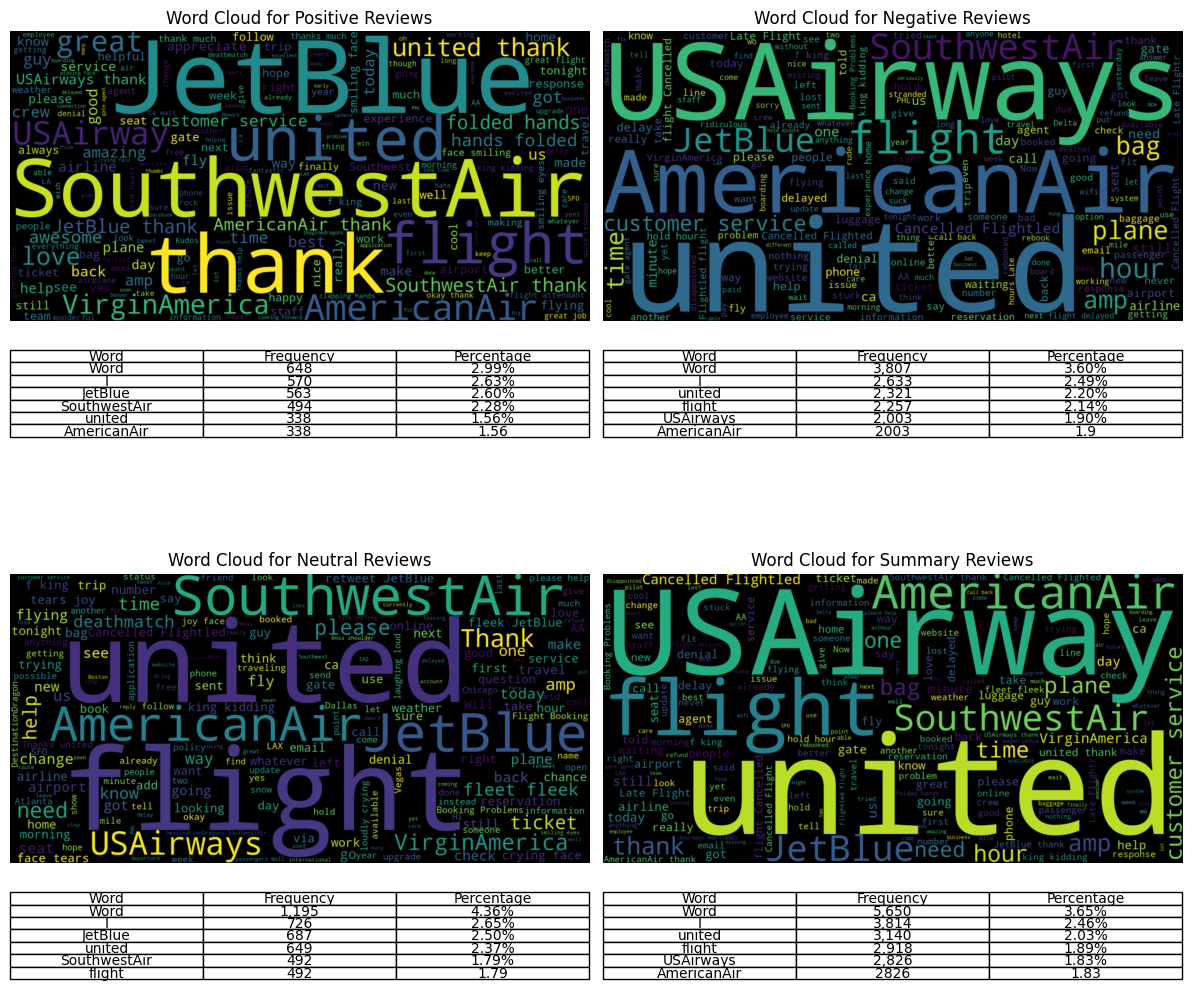

In [686]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.ticker as mticker

# Filter flight_review_df by sentiment categories
positive_reviews = flight_review_df[flight_review_df['airline_sentiment'] == 'positive']
negative_reviews = flight_review_df[flight_review_df['airline_sentiment'] == 'negative']
neutral_reviews = flight_review_df[flight_review_df['airline_sentiment'] == 'neutral']
summary_reviews = flight_review_df['review']

# Generate word clouds and word frequency tables for each sentiment category and summary
sentiments_data = [
    ('Positive', positive_reviews['review']),
    ('Negative', negative_reviews['review']),
    ('Neutral', neutral_reviews['review']),
    ('Summary', summary_reviews)
]

# Adjust the figure size
plt.figure(figsize=(12, 12))

for i, (sentiment, reviews) in enumerate(sentiments_data, 1):
    # Generate word cloud for the current sentiment or summary
    wordcloud = WordCloud(width=1600, height=800).generate(' '.join(reviews))

    # Create a new subplot
    plt.subplot(2, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.axis('off')

    # Calculate word frequencies for the summary
    words_summary = ' '.join(reviews).split()
    word_freq_summary = Counter(words_summary)
    total_words_summary = len(words_summary)
    top_5_summary = [(word, freq, round(freq / total_words_summary * 100, 2)) for word, freq in word_freq_summary.most_common(5)]

    # Adjust the table positioning
    table_data_summary = [['Word', 'Frequency', 'Percentage']] + top_5_summary
    table = plt.table(cellText=table_data_summary, colLabels=['Word', 'Frequency', 'Percentage'],
                      cellLoc='center', loc='bottom', bbox=[0, -0.4, 1, 0.3])

    # Adjust table formatting
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # Apply formatting to numeric values
    for i in range(1, len(table_data_summary)):
        for j in range(1, len(table_data_summary[i])):
            table[i, j].get_text().set_text(
                '{:,.0f}'.format(table_data_summary[i][j]) if j == 1 else '{:.2f}%'.format(table_data_summary[i][j]))

    # Center-align table text
    for key, cell in table._cells.items():
        cell.set_text_props(ha="center", va="center")

# Adjust subplot spacing
plt.tight_layout(pad=1.0)
plt.show()


#### __For Feature Selection and Engineering__:

In [687]:
# # Show the total positive, neutral and negative sentiments for each category
# flight_review_df['roberta_sentiment'].value_counts().unique

In [688]:
# # Transform 'roberta_sentiment' feature into a numerical representation [Negative:0, Neutral:1, Positive:2]
# encoder = LabelEncoder()
# flight_review_df['roberta_sentiment_encoded'] = encoder.fit_transform(flight_review_df['roberta_sentiment'])
# flight_review_df.head(5)

## Model Creation and Evaluation

To rerun once the roBERTa is completed

In [689]:
# # Separate independent variable from dependent variable
# x = flight_review_df['review']
# y = flight_review_df['roberta_sentiment_encoded'].values

# print(f"Independent Features: {x.shape}")
# print(f"Dependent Features: {y.shape}")

In [690]:
# # Split the dataset into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

__Multinomial Naive Bayes using TF-IDF__

In [691]:
# # Vectorize the text data using TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer()
# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)

# # Use Multinomial Naive Bayes to build a model for sentiment analysis
# mnb_tfidf_model = MultinomialNB()
# mnb_tfidf_model.fit(x_train_tfidf, y_train)
# print(f"Model: {mnb_tfidf_model}\n")

# # Model evaluation for the Multinomial Naive Bayes using TfidfVectorizer
# y_pred = mnb_tfidf_model.predict(x_test_tfidf)

# print("Multinomial Naive Bayes using TF-IDF:")
# print(classification_report(y_test, y_pred))

__Multinomial Naive Bayes using CountVectorizer__

In [692]:
# # Vectorize the text data using CountVectorizer
# vectorizer = CountVectorizer()
# x_train_vect = vectorizer.fit_transform(x_train)
# x_test_vect = vectorizer.transform(x_test)

# # Use Multinomial Naive Bayes to build a model for sentiment analysis
# mnb_vc_model = MultinomialNB()
# mnb_vc_model.fit(x_train_vect, y_train)
# print(f"Model: {mnb_vc_model}\n")

# # Model evaluation for the Multinomial Naive Bayes using CountVectorizer
# y_pred = mnb_vc_model.predict(x_test_vect)

# print("Multinomial Naive Bayes using CountVectorizer:")
# print(classification_report(y_test, y_pred))

#### __For Hyperparameter Tuning__:

Specify the evaluation here post hyperparameter tuning

## Group Members
- Auradee Castro
- Bhumika Rajendra Babu
- Miraj Sinya
- Olivia Deguit
- Roger Mais